In [ ]:
import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
import datetime
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from arch import arch_model
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.decomposition import PCA
import requests
from bs4 import BeautifulSoup
from transformers import pipeline
from wordcloud import WordCloud

# Data

In [ ]:
df_original = pd.read_csv("Data/data.csv", index_col=0)

# Features selection

In [ ]:
# Define features and target variable
X = df_original.drop(columns=["SP500_Volatility_20d"])  # Keep only exogenous variables
y = df_original["SP500_Volatility_20d"]  # Target variable

print("Number of features before selection: ", X.shape[1])

# Standardize features (Elastic Net is sensitive to feature scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Use ElasticNetCV to find the best alpha (regularization strength) and l1_ratio (balance between L1 & L2)
# elastic_cv = ElasticNetCV(
#     cv=5, 
#     l1_ratio=[0.1, 0.5, 0.9, 1.0], 
#     alphas=np.logspace(-4, 0, 50), 
#     max_iter=5000,  # Increased from default 1000
#     random_state=42
# )
# elastic_cv.fit(X_train, y_train)

# Train Elastic Net with best hyperparameters
# elastic_net = ElasticNet(alpha=elastic_cv.alpha_, l1_ratio=elastic_cv.l1_ratio_, random_state=42)
elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.9, max_iter=5000, random_state=42)
elastic_net.fit(X_train, y_train)

# Get feature importance (non-zero coefficients)
selected_features = X.columns[elastic_net.coef_ != 0]

# Print selected features
print("Number of features after selection: ", len(selected_features))
print("Selected Features:", list(selected_features))

Number of features before selection:  136
Number of features after selection:  8
Selected Features: ['Nikkei_Volatility_20d', 'Stoxx_Close', 'Stoxx_Volatility_20d', 'Gas_Close', 'Gas_Volatility_20d', 'GBP/USD_Volatility_20d', 'US HY Bonds_Volatility_20d', 'SP500_EMA26']


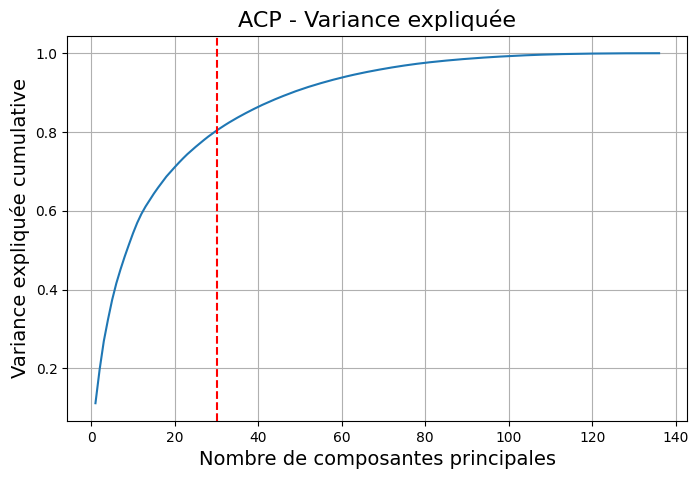

In [ ]:
# Define features (excluding target variable 'Volatility')
X = df_original.drop(columns=["SP500_Volatility_20d"])

# Standardize features (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance)
plt.axvline(x=30, color='r', linestyle='--')
plt.xlabel("Nombre de composantes principales", fontsize=14)
plt.ylabel("Variance expliquée cumulative", fontsize=14)
plt.title("ACP - Variance expliquée", fontsize=16)
plt.grid(True)
plt.show()

In [6]:
print("Number of features before selection: ", X.shape[1])

# Standardize features (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.80)  # Retains 80% of variance
X_pca = pca.fit_transform(X_scaled)

# Print number of selected components
print(f"Number of components selected: {pca.n_components_}")

# Create a DataFrame with PCA features
pca_columns = [f"PC{i+1}" for i in range(pca.n_components_)]
X_pca_df = pd.DataFrame(X_pca, columns=pca_columns)

Number of features before selection:  136
Number of components selected: 30


In [7]:
X_pca_df["SP500_Volatility_20d"] = df_original["SP500_Volatility_20d"].values
X_pca_df["SP500_Returns"] = df_original["SP500_Returns"].values
X_pca_df.index = pd.to_datetime(df_original.index)
df = X_pca_df
df.shape

(1191, 32)

# Visualisation

In [9]:
def print_metrics_and_plot(y_test, y_pred):

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
    r2 = r2_score(y_test, y_pred)            # R-squared (coefficient of determination)

    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R-squared: {r2:.4f}")

    # Visualize the results
    fig = plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label="True Volatility")
    plt.plot(y_test.index, y_pred, label="Predicted Volatility")
    plt.title(f"Predicted vs True Volatility", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Volatility", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=14)
    plt.show()

# Autoregressive prediction

In [10]:
prediction_horizon = 20 #day

train_size = int(0.8 * len(df))

X_train = df["SP500_Returns"][:train_size-prediction_horizon]
X_test = df["SP500_Returns"][train_size:-prediction_horizon]
y_train = df["SP500_Volatility_20d"][:train_size].shift(-prediction_horizon).dropna()
y_test = df["SP500_Volatility_20d"][train_size:].shift(-prediction_horizon).dropna()

### EWMA (Exponential Weighted Moving Average)

$$\sigma_n^2 = \lambda \sigma_{n-1}^2 + (1-\lambda) r_{n-1}^2$$

Mean Squared Error: 0.0029
R-squared: -0.9438


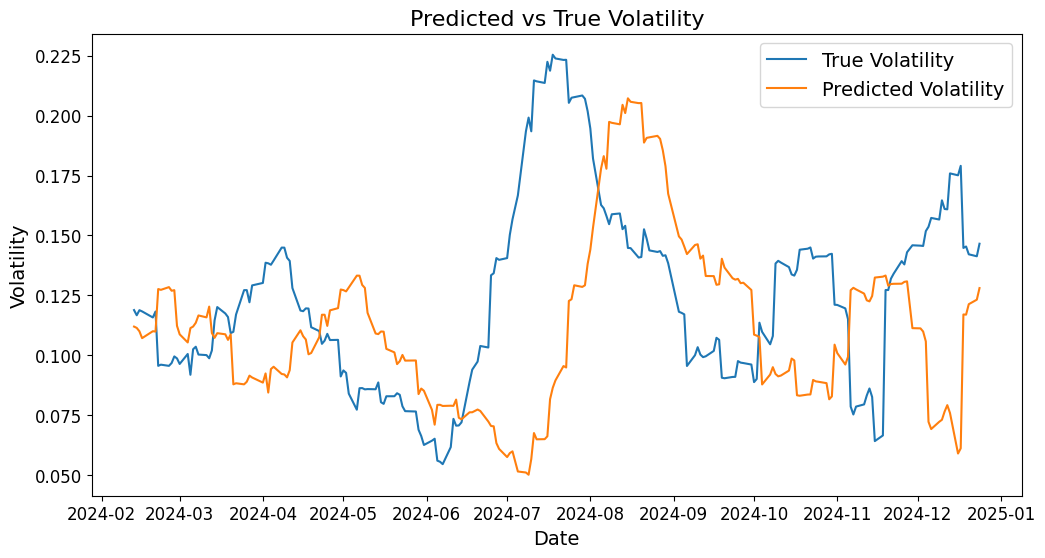

In [11]:
# Fit the best lambda for EWMA on the training set
best_mse = np.inf
best_lambda = 0
for l in np.linspace(0, 1, 100):
    y_pred = l*X_train**2 + (1-l)*df["SP500_Volatility_20d"][:train_size-prediction_horizon]
    mse = ((y_pred - y_train)**2).mean()
    if mse < best_mse:
        best_mse = mse
        best_lambda = l

# Predict the volatility on the test set
y_pred = best_lambda*X_test**2 + (1-best_lambda)*df["SP500_Volatility_20d"][train_size:-prediction_horizon]

# Compute performance metrics
print_metrics_and_plot(y_test, y_pred)

### GARCH (Generalized Autoregressive Conditional Heteroskedasticity)

$$\sigma_n^2 = \gamma \sigma_{\infty}^2 + \alpha r_{n-1}^2 + \beta \sigma_{n-1}^2$$

<ipython-input-12-de1398ed9c2e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma2[i] = alpha*long_term_vol + beta*y_train[i-prediction_horizon]**2 + gamma*X_train[i-prediction_horizon]**2


Mean Squared Error: 0.0024
R-squared: -0.6347


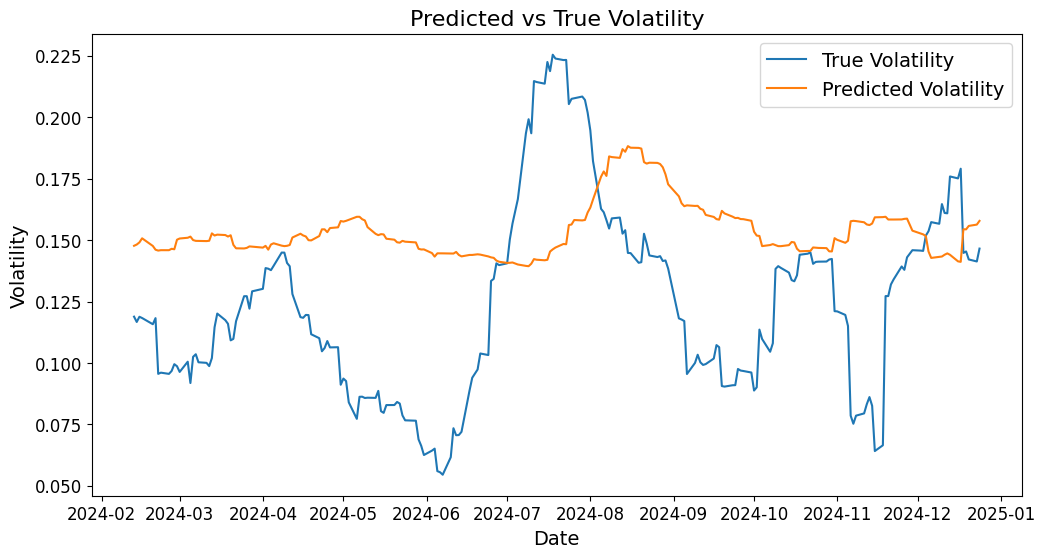

In [12]:
long_term_vol = y_train.mean()

# Fit the best parameters for GARCH(1,1) on the training set
best_mse = np.inf
best_alpha, best_beta, best_gamma = 0, 0, 0
for alpha in np.linspace(0, 1, 10):
    for beta in np.linspace(0, 1, 10):
        for gamma in np.linspace(0, 1, 10):
            sigma2 = np.zeros(X_train.shape[0])
            for i in range(prediction_horizon, X_train.shape[0]):
                sigma2[i] = alpha*long_term_vol + beta*y_train[i-prediction_horizon]**2 + gamma*X_train[i-prediction_horizon]**2
            y_pred = np.sqrt(sigma2)
            mse = ((y_pred - y_train)**2).mean()
            if mse < best_mse:
                best_mse = mse
                best_alpha, best_beta, best_gamma = alpha, beta, gamma


# Predict the volatility on the test set
y_pred = np.zeros(X_test.shape[0])
for i in range(prediction_horizon):
    y_pred[i] = np.sqrt(best_alpha*long_term_vol + best_beta*y_train.iloc[-prediction_horizon+i]**2 + best_gamma*X_train.iloc[-prediction_horizon+i]**2)
for i in range(prediction_horizon, X_test.shape[0]):
    y_pred[i] = np.sqrt(best_alpha*long_term_vol + best_beta*y_test.iloc[i-prediction_horizon]**2 + best_gamma*X_test.iloc[i-prediction_horizon]**2)

# Compute performance metrics
print_metrics_and_plot(y_test, y_pred)

Mean Squared Error: 0.0097
R-squared: -5.5345


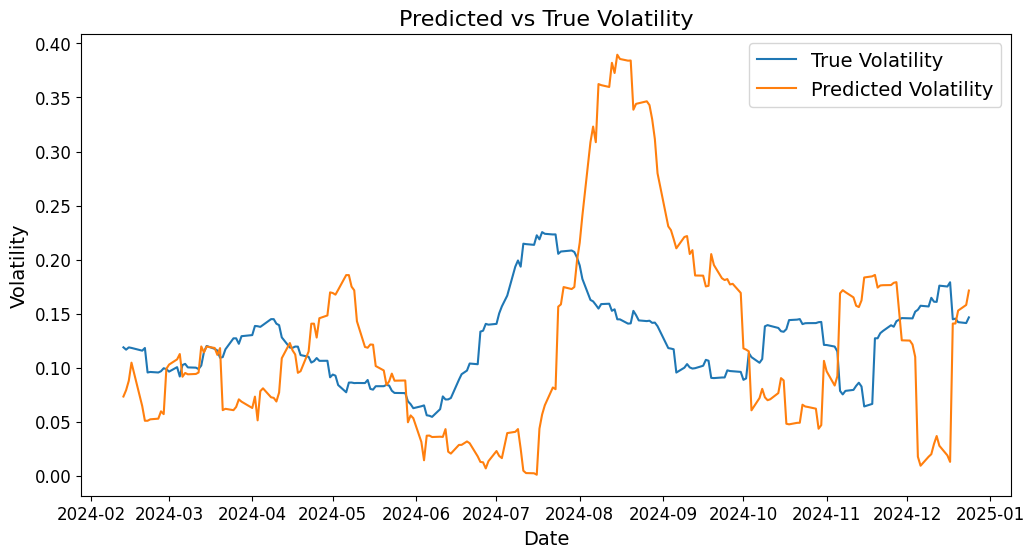

In [13]:
model = arch_model(X_train*100, vol='GARCH', p=1, q=1)  # This function takes the returns in percentage as input
model_fit = model.fit(disp="off")

# Initialize an array to store the predictions
y_pred_garch = np.zeros(X_test.shape[0])

# Step 3: Make volatility predictions using the fitted model
for i in range(prediction_horizon):
    new_return = model_fit.forecast(horizon=1).mean.values[-1][0]
    y_pred_garch[i] = np.std([new_return, y_train.iloc[-prediction_horizon+i]]) * np.sqrt(252)
for i in range(prediction_horizon, X_test.shape[0]):
    new_return = model_fit.forecast(horizon=1).mean.values[-1][0]
    y_pred_garch[i] = np.std([new_return, y_test.iloc[i-prediction_horizon]]) * np.sqrt(252)

y_pred_garch *= np.mean(y_test) / np.mean(y_pred_garch) # I don't know why I have to do this but otherwise the prediction does not appear at the same scale as the true volatility

# Compute performance metrics
print_metrics_and_plot(y_test, y_pred_garch)

pas d'amélioration même avec variables exogènes

# Machine learning

In [14]:
X_train = df[:train_size-prediction_horizon]
X_test = df[train_size:-prediction_horizon]
y_train = df["SP500_Volatility_20d"][:train_size].shift(-prediction_horizon).dropna()
y_test = df["SP500_Volatility_20d"][train_size:].shift(-prediction_horizon).dropna()

### Linear regression

Mean Squared Error: 0.0064
R-squared: -3.3278


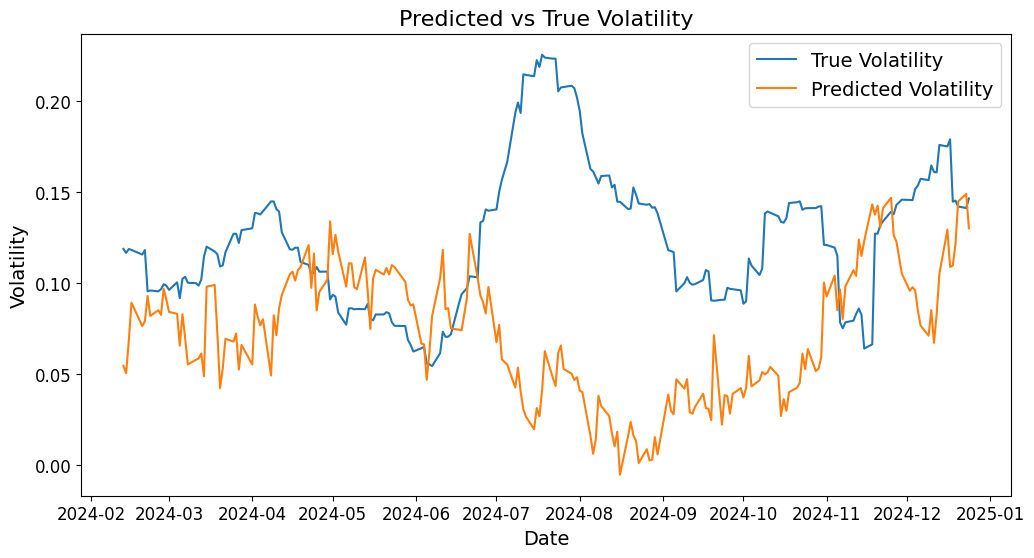

In [15]:
# Initialize the Linear Regression model
lr = LinearRegression()

# Train the model on the training data
lr.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lr.predict(X_test)

# Evaluate the model and plot the results
print_metrics_and_plot(y_test, y_pred)

### Random forest

Mean Squared Error: 0.0017
R-squared: -0.1304


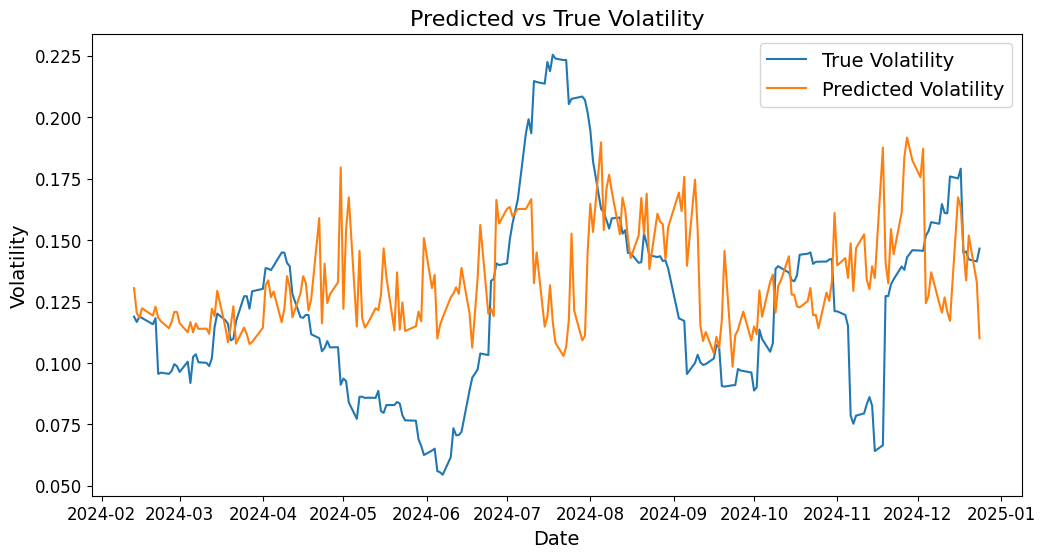

In [16]:
# Initialize the Random Forest Regressor model
rf = RandomForestRegressor(n_estimators=100, random_state=42)  # You can tune hyperparameters

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Evaluate the model and plot the results
print_metrics_and_plot(y_test, y_pred)

### SVM

Best hyperparameters: {'C': 0.01, 'epsilon': 0.001, 'gamma': 0.01}
Mean Squared Error: 0.0023
R-squared: -0.5804


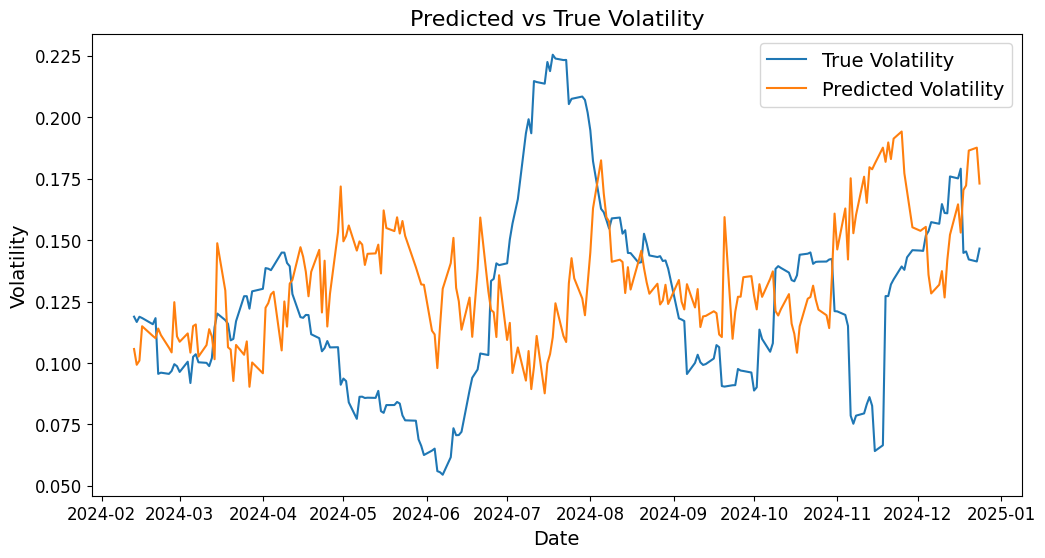

In [17]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Support Vector Regressor model
svr = SVR(kernel="rbf")

# Define a grid of hyperparameters to search
param_grid = {
    'C': [.001, 0.01, 0.1, 1],
    'gamma': [0.01, 0.001, 1e-4],
    'epsilon': [.001, 0.05, 0.1, 0.2]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Best model from grid search
best_svr = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_svr.predict(X_test_scaled)

# Evaluate the model and plot the results
print_metrics_and_plot(y_test, y_pred)

### XGBoost

Mean Squared Error: 0.0019
R-squared: -0.2660


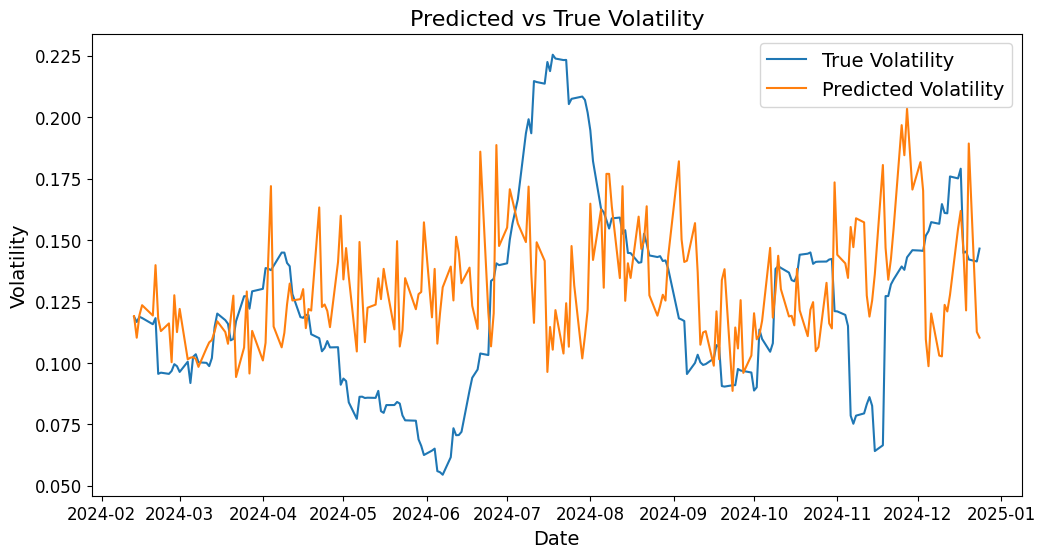

In [18]:
# Initialize the XGBoost Regressor model
xgb = XGBRegressor(n_estimators=100, random_state=42)  # You can tune hyperparameters

# Train the model on the training data
xgb.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb.predict(X_test)

# Evaluate the model and plot the results
print_metrics_and_plot(y_test, y_pred)

## Bayesian method

Epoch 0, Loss: 10.578601837158203
Epoch 100, Loss: 0.3103099465370178
Epoch 200, Loss: -0.3050447106361389
Epoch 300, Loss: -0.36616262793540955
Epoch 400, Loss: -0.3661666214466095
Epoch 500, Loss: -0.3661666214466095
Epoch 600, Loss: -0.3661666214466095
Epoch 700, Loss: -0.3661664128303528
Epoch 800, Loss: -0.3661666214466095
Epoch 900, Loss: -0.3661665916442871
Mean Squared Error: 0.0010
R-squared: 0.2789


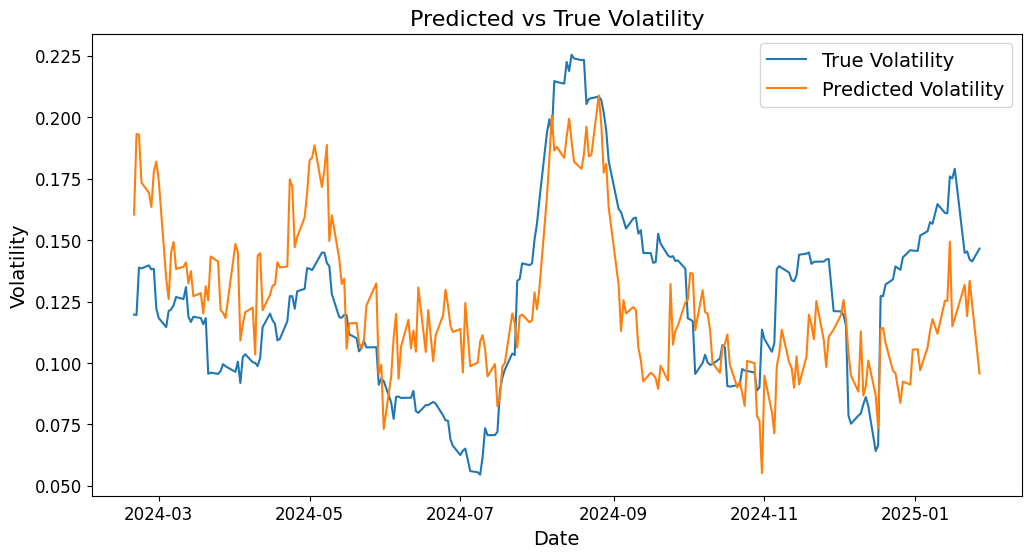

Mean Squared Error: 0.0010
R-squared: 0.2789


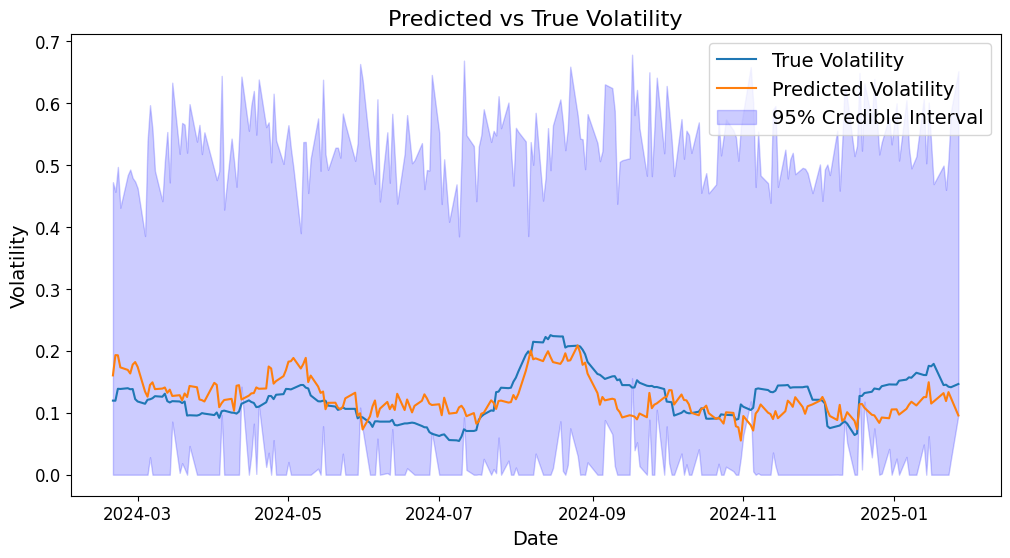

In [21]:
# Function to create lagged features
def create_lagged_features(data, lags):
    lagged_data = data.copy()
    for lag in range(1, lags + 1):
        lagged_data[f'lag_{lag}'] = lagged_data['SP500_Returns'].shift(lag)
    lagged_data = lagged_data.dropna()
    return lagged_data

# Choose the number of lags and prediction horizon
lags = 20
prediction_horizon = 20

# Create lagged features
df_lagged = create_lagged_features(df, lags)

# Split the data into training and testing sets
train_data, test_data = train_test_split(df_lagged, test_size=0.2, shuffle=False)

# Prepare the data for the model
train_features = train_data.drop(['SP500_Returns', 'SP500_Volatility_20d'], axis=1).values.astype(np.float32)
train_volatility = train_data['SP500_Volatility_20d'].values.astype(np.float32)

test_features = test_data.drop(['SP500_Returns', 'SP500_Volatility_20d'], axis=1).values.astype(np.float32)
test_volatility = test_data['SP500_Volatility_20d'].values.astype(np.float32)

# Normalize the features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

# Define the Bayesian linear regression model using TFP
class BayesianLinearModel(tf.Module):
    def __init__(self):
        # Priors for the coefficients and noise
        self.coeff_prior = tfp.distributions.Normal(loc=0., scale=0.1)
        self.noise_prior = tfp.distributions.Cauchy(loc=0., scale=0.1)

        # Initialize variables with smaller scale
        self.coeffs = tf.Variable(self.coeff_prior.sample(train_features.shape[1]), name='coeffs', dtype=tf.float32)
        self.noise = tf.Variable(self.noise_prior.sample(), name='noise', dtype=tf.float32)

    def __call__(self, features):
        # Predictive distribution
        pred_dist = tfp.distributions.Normal(
            loc=tf.tensordot(features, self.coeffs, axes=[[1], [0]]),
            scale=tf.math.abs(self.noise) + 1e-5  # Ensure positive scale
        )
        return pred_dist

# Instantiate the model
model = BayesianLinearModel()

# Define the negative log-likelihood loss function
def neg_log_likelihood(y_true, pred_dist):
    return -tf.reduce_mean(pred_dist.log_prob(y_true))

# Compile the model with a lower learning rate
optimizer = tf.optimizers.Adam(learning_rate=0.001)

@tf.function
def train_step(features, volatility, model):
    with tf.GradientTape() as tape:
        pred_dist = model(features)
        loss = neg_log_likelihood(volatility, pred_dist)
        # Add L2 regularization
        loss += 0.01 * tf.reduce_sum(tf.square(model.coeffs))
    gradients = tape.gradient(loss, model.trainable_variables)
    # Apply gradient clipping
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    loss = train_step(train_features, train_volatility, model)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Make predictions for the specified horizon
num_samples = 500  # Number of samples to draw from the posterior
predictions = []
current_features = test_features.copy()

for _ in range(prediction_horizon):
    pred_dist = model(current_features)
    samples = pred_dist.sample(num_samples).numpy()
    y_pred = np.mean(samples, axis=0)
    predictions.append(y_pred)

    # Update features for the next prediction
    current_features = np.roll(current_features, -1, axis=1)
    current_features[:, -1] = y_pred  # Assuming the last feature is the most recent lag

# Convert predictions to a numpy array
predictions = np.array(predictions).flatten()

# Ensure the number of predictions matches the available test data
num_test_samples = min(len(predictions), len(test_volatility))

# Calculate credible intervals
lower_bounds = np.percentile(samples, 5, axis=0)
upper_bounds = np.percentile(samples, 95, axis=0)

# Evaluate the model
def print_metrics_and_plot(y_test, y_pred, lower_bounds=None, upper_bounds=None):
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
    r2 = r2_score(y_test, y_pred)            # R-squared (coefficient of determination)

    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R-squared: {r2:.4f}")

    # Visualize the results
    fig = plt.figure(figsize=(12, 6))
    plt.plot(y_test.index[:num_test_samples], y_test[:num_test_samples], label="True Volatility")
    plt.plot(y_test.index[:num_test_samples], y_pred[:num_test_samples], label="Predicted Volatility")
    if lower_bounds is not None:
        plt.fill_between(y_test.index[:num_test_samples], lower_bounds[:num_test_samples], upper_bounds[:num_test_samples], color='b', alpha=0.2, label="95% Credible Interval")
    plt.title(f"Predicted vs True Volatility", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Volatility", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=14)
    plt.show()

shift = test_data['SP500_Volatility_20d'].iloc[:num_test_samples].mean() - predictions[:num_test_samples].mean()

print_metrics_and_plot(test_data['SP500_Volatility_20d'].iloc[:num_test_samples], predictions[:num_test_samples]+shift)
print_metrics_and_plot(test_data['SP500_Volatility_20d'].iloc[:num_test_samples], predictions[:num_test_samples]+shift, np.maximum(0,lower_bounds[:num_test_samples]+shift), upper_bounds[:num_test_samples]+shift)

# Deep learning
## LSTM

In [ ]:
def print_metrics_and_plot_lstm(y_test, y_pred, y_pred_std=None):

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
    r2 = r2_score(y_test, y_pred)            # R-squared (coefficient of determination)

    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R-squared: {r2:.4f}")

    plt.figure(figsize=(12,6))
    plt.plot(df.index[-y_test.shape[0]:], y_test[:, 0], label="True Volatility")
    plt.plot(df.index[-y_test.shape[0]:], y_pred[:, 0], label="Predicted Volatility")

    # Plot the uncertainty range
    if y_pred_std is not None:
        plt.fill_between(df.index[-y_test.shape[0]:],
                         y_pred[:, 0] - y_pred_std[:, 0],
                         y_pred[:, 0] + y_pred_std[:, 0],
                         color='b', alpha=0.2, label='Uncertainty Range')
    plt.title(f"Predicted vs True Volatility", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Volatility", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=14)
    plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Mean Squared Error: 0.0018
R-squared: -0.3313


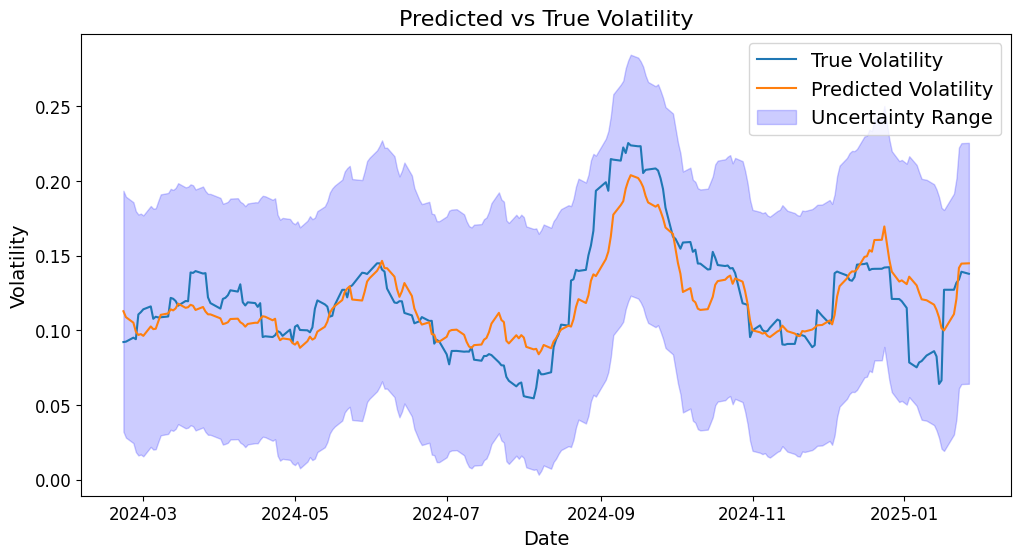

In [ ]:
def create_sequences(data, seq_length, horizon):
    sequences = []
    for i in range(len(data) - seq_length - horizon + 1):
        seq = data.iloc[i:i + seq_length]
        label = data['SP500_Volatility_20d'].iloc[i + seq_length:i + seq_length + horizon].values
        sequences.append((seq, label))
    return sequences

# Assuming df is your DataFrame and 'SP500_Volatility_20d' is the target column
# Normalize the data
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Separate features and target for scaling
features = df.drop(columns=['SP500_Volatility_20d'])
target = df[['SP500_Volatility_20d']]

scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(target)

# Combine scaled features and target into a DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=features.columns)
scaled_data['SP500_Volatility_20d'] = scaled_target

# Define sequence length and prediction horizon
seq_length = 10
horizon = 20  # Number of future time steps to predict

# Create sequences
sequences = create_sequences(scaled_data, seq_length, horizon)

# Split into features and labels
X, y = zip(*sequences)
X, y = np.array(X), np.array(y)

# Split into training and test sets
train_size = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, X_train.shape[2])))
model.add(Dense(horizon))  # Output layer with 'horizon' number of neurons
model.compile(optimizer='adam', loss='mse')

# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Make predictions
y_pred = model.predict(X_test)

# For simplicity, let's assume a constant standard deviation for the uncertainty range
y_pred_std = np.std(y_pred, axis=0).reshape(1, -1) * np.ones_like(y_pred)

# Inverse the scaling for the target variable
y_test_inv = scaler_target.inverse_transform(y_test)
y_pred_inv = scaler_target.inverse_transform(y_pred)
y_pred_std_inv = scaler_target.inverse_transform(y_pred_std)

# Plot the results with uncertainty range
print_metrics_and_plot_lstm(y_test_inv, y_pred_inv, y_pred_std_inv)

# Perspective d'amélioration: Sentiment analysis

In [22]:
def scrap_google_news(ticker, nb_news):
    url = f'https://news.google.com/rss/search?q={ticker}'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'xml')
    items = soup.findAll('item')

    news = []
    for item in items[:nb_news]:
        news.append({
            'Source': "Google News",
            'Ticker': ticker,
            'Title': item.title.text,
            #'link': item.link.text,
            'Date': item.pubDate.text
        })
    data = pd.DataFrame(news)
    data['Date'] = pd.to_datetime(data['Date'], format="%a, %d %b %Y %H:%M:%S %Z").dt.date
    return data

In [ ]:
def scrap_finviz_news(ticker, nb_news=5):
    url = f"https://finviz.com/quote.ashx?t={ticker}"
    headers = {'User-Agent': 'Mozilla/5.0'}  # Set User-Agent to avoid getting blocked
    response = requests.get(url, headers=headers)

    # Check if the request was successful
    if response.status_code != 200:
        print(f"Failed to retrieve data for {ticker}: {response.status_code}")
        return []

    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the news table
    news_table = soup.find(id='news-table')
    
    news_titles = []
    if news_table:
        rows = news_table.find_all('tr')
        for row in rows[:nb_news]:
            # The news title is usually in the second column
            title_column = row.find_all('td')[1] if len(row.find_all('td')) > 1 else None
            if title_column:
                title = title_column.get_text(strip=True)
                #link = title_column.find('a')['href'] if title_column.find('a') else None
                date = row.find_all('td')[0].get_text(strip=True)
                news_titles.append({'Source': "Finviz",
                                    'Ticker': ticker,
                                    'Title': title,
                                    #'link': link,
                                    'Date': date})
    data = pd.DataFrame(news_titles)
    #Change the date format to have a datetime object
    for i in range(len(data)):
        if("Today" in data.loc[i, 'Date']):
            data.loc[i, 'Date'] = data.loc[i, 'Date'].replace("Today", datetime.datetime.datetime.today().strftime('%b-%d-%y'))
        elif(data.loc[i, 'Date'][0] in '0123456789'):
            data.loc[i, 'Date'] = str(data.loc[i-1, 'Date'])[:10]+" "+data.loc[i, 'Date']
    data['Date'] = pd.to_datetime(data['Date'], format="%b-%d-%y %I:%M%p").dt.date
    return data

In [24]:
nb_news = 1000
df_news = scrap_google_news('SP500', nb_news)
df_news = pd.concat([df_news, scrap_google_news('SPX', nb_news)], ignore_index=True)
df_news = pd.concat([df_news, scrap_finviz_news('SPY', nb_news)], ignore_index=True)

TextBlob and VADER are two popular sentiment analysis tools but seem to be too general for financial news. Even BERT seems to struggle with some financial news.

In [25]:
# Load sentiment analysis pipeline
# model from https://huggingface.co/ProsusAI/finbert
sentiment_analysis = pipeline("sentiment-analysis", model="ProsusAI/finbert")

# Function to get sentiment using BERT
def get_sentiment_bert(text):
    result = sentiment_analysis(text)
    dico = {"positive":1, "neutral":0, "negative":-1}
    return dico[result[0]['label']], result[0]['score']

# Apply sentiment analysis
df_news['sentiment_score'], df_news['sentiment_confidence'] = zip(*df_news['Title'].apply(get_sentiment_bert))

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


In [26]:
df_news

,Source,Ticker,Title,Date,sentiment_score,sentiment_confidence
0,Google News,SP500,Trump 'bump' disappears as the S&P 500 is now ...,2025-03-04,-1,0.554065
1,Google News,SP500,Veteran fund manager who correctly forecast S&...,2025-03-05,-1,0.667896
2,Google News,SP500,"Tariffs Live Updates: Dow, S&P 500 Rise After ...",2025-03-05,1,0.709624
3,Google News,SP500,Stock Market Today: Dow jumps more than 400 po...,2025-03-05,1,0.499676
4,Google News,SP500,Why Are European Stocks Beating the S&P 500 Th...,2025-03-03,0,0.842343
...,...,...,...,...,...,...
297,Finviz,SPY,Santa Rally Kicks Off On Wall Street: Stocks G...,2024-12-24,1,0.854122
298,Finviz,SPY,Americans are less confident about where the U...,2024-12-23,0,0.788547
299,Finviz,SPY,Want to Invest Like Warren Buffett -- but on a...,2024-12-22,0,0.921044
300,Finviz,SPY,ETF Market Sets Records In 2024 As Inflows Rea...,2024-12-19,1,0.492930


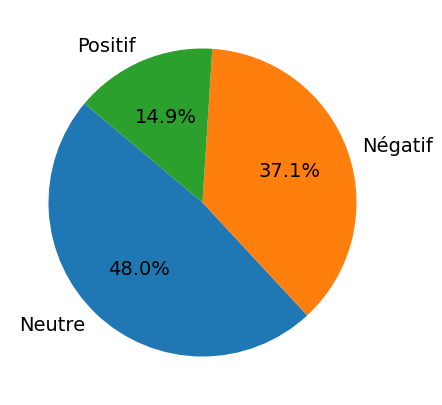

In [27]:
sentiment_counts = df_news['sentiment_score'].replace({1:'Positif', 0:'Neutre', -1:'Négatif'}).value_counts()
plt.figure(figsize=(5,5))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14})
#plt.title('Sentiment Distribution of News Headlines')
plt.show()

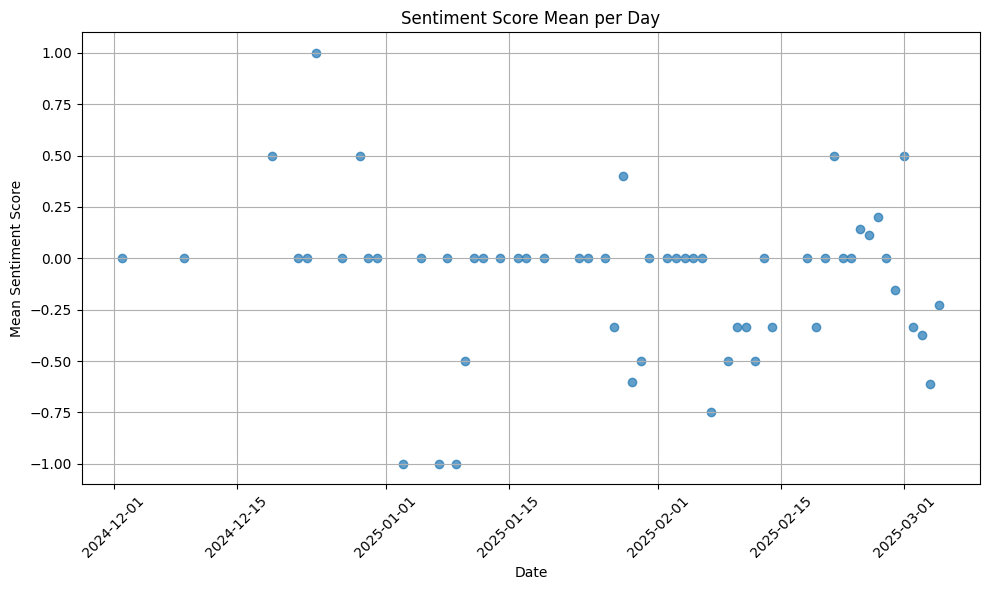

In [28]:
df_temp = df_news.groupby(['Date'])['sentiment_score'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.scatter(df_temp['Date'], df_temp['sentiment_score'], alpha=0.7)
plt.title('Sentiment Score Mean per Day')
plt.xlabel('Date')
plt.ylabel('Mean Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

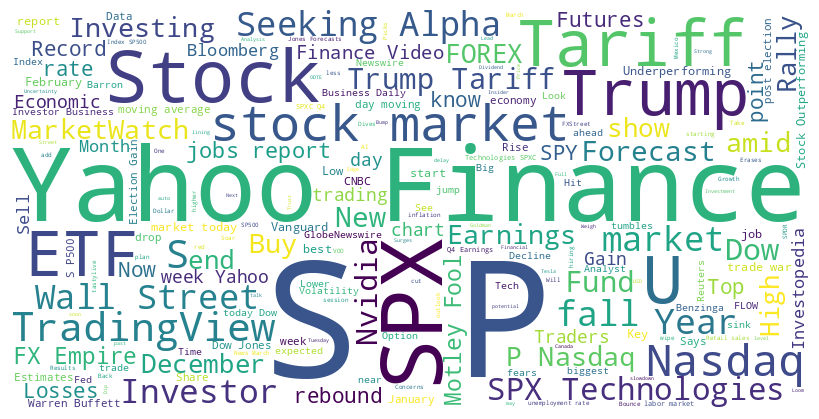

In [29]:
text = ' '.join(df_news['Title'].values)

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)

# Display the generated image:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()